In [37]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# load in data from mnist
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [39]:
#create the dataloaders: 
batch_size = 1024

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X,y in train_dataloader:
    print(f"X shape [NCHW]: {X.shape}")
    print(f"y shape: {y.shape}")
    break

X shape [NCHW]: torch.Size([1024, 1, 28, 28])
y shape: torch.Size([1024])


In [45]:
#define the device and the model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

model = nn.Sequential(
    nn.Conv2d(1,8,5),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(8,16,5),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,10)
)

Using device cuda


In [46]:
#optimiazer, loss and training

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
train_accuracies =[]

def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    model.train()
    
    losses,accuracies = [],[]
    for lvb, (X,y) in enumerate(dataloader):
        X.to(device), y.to(device)

        #forward pass
        mx = model(X)
        loss = loss_fn(mx,y)

        #gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # append loss and accuracy for recording
        losses.append(loss.item())
        acc = (y == mx.max(dim=1)[1]).mean(dtype = float).item()
        accuracies.append(acc)

        #print for floowing
        if lvb % 10 == 0:
            loss, current = loss.item(), lvb * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = np.mean(losses)
    train_acc = np.mean(accuracies)
    
    return train_loss, train_acc
            

In [47]:
def test(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval()
    
    with torch.no_grad():
        test_loss,correct = 0,0
        for lvb, (X,y) in enumerate(dataloader):
            X.to(device), y.to(device)
            
            #forward pass
            mx = model(X)
            loss = loss_fn(mx,y)
            
            # append loss and accuracy for recording
            test_loss += loss.item()
            correct += (y == mx.max(dim=1)[1]).sum(dtype = float).item()
                
    test_loss /= num_batches
    acc = correct / size
    print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, acc

In [48]:
#train:
num_epochs = 10
train_losses,train_accs, test_losses, test_accs = [],[],[],[]

print(f"PRE-TRAINING:\n-------------------------------")
#test + record
test_loss,test_acc = test(test_dataloader,model,loss_fn)
test_losses.append(test_loss)
test_accs.append(test_acc)

for lve in range(num_epochs):
    print(f"Epoch {lve+1}\n-------------------------------")
    #train + record
    train_loss, train_acc = train(train_dataloader,model,loss_fn,optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    #test + record
    test_loss,test_acc = test(test_dataloader,model,loss_fn)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

PRE-TRAINING:
-------------------------------
Test Error: 
 Accuracy: 8.7%, Avg loss: 2.311836 

Epoch 1
-------------------------------
loss: 2.312287  [    0/60000]
loss: 2.280179  [10240/60000]
loss: 2.216375  [20480/60000]
loss: 2.063590  [30720/60000]
loss: 1.744850  [40960/60000]
loss: 1.252218  [51200/60000]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.834858 

Epoch 2
-------------------------------
loss: 0.845440  [    0/60000]
loss: 0.543350  [10240/60000]
loss: 0.547741  [20480/60000]
loss: 0.572918  [30720/60000]
loss: 0.470791  [40960/60000]
loss: 0.401937  [51200/60000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.366100 

Epoch 3
-------------------------------
loss: 0.393197  [    0/60000]
loss: 0.301867  [10240/60000]
loss: 0.366200  [20480/60000]
loss: 0.416781  [30720/60000]
loss: 0.333809  [40960/60000]
loss: 0.300208  [51200/60000]
Test Error: 
 Accuracy: 91.8%, Avg loss: 0.279171 

Epoch 4
-------------------------------
loss: 0.302465  [    0/60000]
loss: 0.225154  [

Text(0, 0.5, 'Average accuracy')

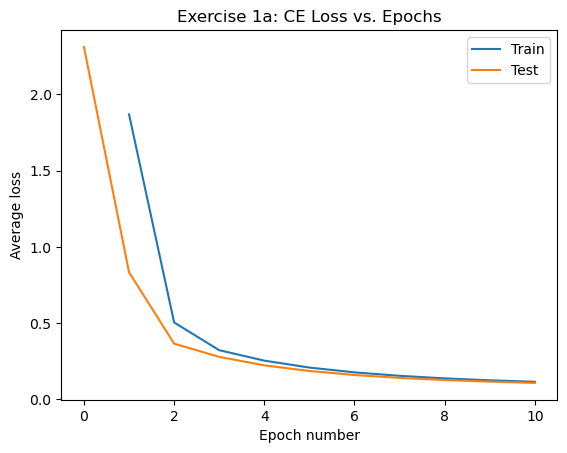

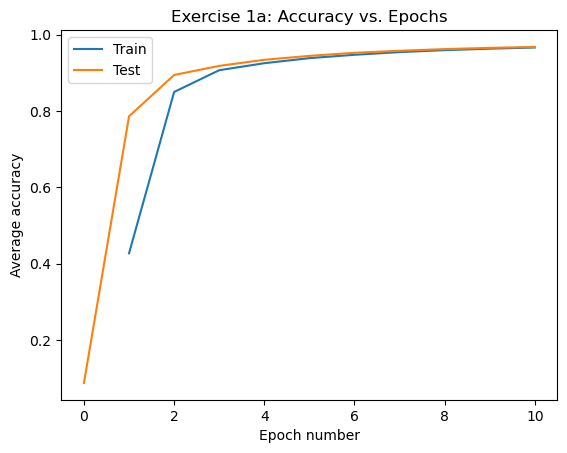

In [54]:
t= np.linspace(1,num_epochs,num_epochs)
plt.plot(t, train_losses)
plt.plot( [0] + list(t), test_losses)
plt.legend(["Train","Test"])
plt.title("Exercise 1a: CE Loss vs. Epochs")
plt.xlabel("Epoch number")
plt.ylabel("Average loss")

plt.figure()
plt.plot(t, train_accs)
plt.plot( [0] + list(t), test_accs)
plt.legend(["Train","Test"])
plt.title("Exercise 1a: Accuracy vs. Epochs")
plt.xlabel("Epoch number")
plt.ylabel("Average accuracy")
